In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', 30)

In [3]:
df = pd.read_csv("data/df_post_EDA.csv", index_col=0)
df.head()

,user_ID,chapter_ID,relative_renewal_date,P,A,L,M,S,RGI,RGO,RRI,RRO,V,1-2-1,TYFCB,CEU,year_of_membership,chapter_size,chapter_retention_rate,chapter_growth_rate,seat_popularity_rate,total_meetings,wont_renew
0,0,31,2016-04-01,33,0,0,1,0,21,7,33,32,1,37,129784,45,0,32,0.315789,1.421053,0.076923,34,0
1,2,18,2017-05-01,33,2,2,0,0,6,17,11,22,1,26,9285,1,0,34,0.718750,1.093750,0.266667,37,0
2,2,18,2018-05-01,35,1,0,0,2,6,24,19,36,1,20,7263,10,1,21,0.424242,0.636364,0.210526,38,0
3,2,18,2019-05-01,36,0,0,0,1,9,8,23,19,3,28,1860,31,2,22,0.739130,1.217391,0.263158,37,0
4,2,18,2020-05-01,33,1,0,0,3,10,13,19,47,4,30,6668,16,3,26,0.760000,1.120000,0.277778,37,0


### Drop & split

In [4]:
df.drop(["user_ID", "relative_renewal_date"], axis=1, inplace=True)

In [5]:
df["P_by_A"] = df["P"] / (df["A"] + 1)
df["P_by_M"] = df["P"] / (df["M"] + 1)
df["P_by_S"] = df["P"] / (df["S"] + 1)
df["P_by_total"] = df["P"] / df["total_meetings"]
df["A_by_total"] = df["A"] / df["total_meetings"]
df["M_by_total"] = df["M"] / df["total_meetings"]

df["P_tim_retention"] = df["P"] * df["chapter_retention_rate"]
df["P_tim_growth"] = df["P"] * df["chapter_growth_rate"]
df["P_tim_popularity"] = df["P"] * df["seat_popularity_rate"]
df["P_tim_V"] = df["P"] * df["V"]
df["P2_tim_V"] = df["P"]**2 * df["V"]
df["P_tim_TYFCB"] = df["P"] * df["TYFCB"]

df["year_tim_retention"] = df["year_of_membership"] * df["chapter_retention_rate"]

df["P2"] = df["P"]**2

columns_list = df.columns.tolist()
columns_list.remove("wont_renew")

columns_list+= ["wont_renew"]
df = df[columns_list]

### Final pick

In [6]:
logreg_10_features = pd.read_csv("feature_selection/pick_10_features_logreg.csv", index_col=0)
logreg_10_features = logreg_10_features["feature_name"].tolist()

dt_10_features = pd.read_csv("feature_selection/pick_10_features_dt.csv", index_col=0)
dt_10_features = dt_10_features["feature_name"].tolist()

rf_10_features = pd.read_csv("feature_selection/pick_10_features_rf.csv", index_col=0)
rf_10_features = rf_10_features["feature_name"].tolist()

ada_10_features = pd.read_csv("feature_selection/pick_10_features_ada.csv", index_col=0)
ada_10_features = ada_10_features["feature_name"].tolist()

xgb_10_features = pd.read_csv("feature_selection/pick_10_features_xgb.csv", index_col=0)
xgb_10_features = xgb_10_features["feature_name"].tolist()

catboost_10_features = pd.read_csv("feature_selection/pick_10_features_catboost.csv", index_col=0)
catboost_10_features = catboost_10_features["feature_name"].tolist()

# Model

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from catboost import CatBoostClassifier, Pool
import xgboost as xgb

import scikitplot as skplt

from sklearn.calibration import CalibratedClassifierCV
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

from imblearn.under_sampling import EditedNearestNeighbours, TomekLinks, NeighbourhoodCleaningRule
from imblearn.over_sampling import SMOTE, ADASYN
from collections import Counter

In [8]:
df_scores = pd.DataFrame(columns=["training_time [s]", "accuracy", "precision", "recall", "f1", "auc"])

labels = []
errors_uncalibrated = []
errors_isotonic = []
errors_sigmoid = []

## 1. Logistic Regression

In [9]:
X = df.drop(["wont_renew", "chapter_ID"], axis=1).copy()
y = df["wont_renew"].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=710)

under_sampler = TomekLinks()
X_resampled, y_resampled = under_sampler.fit_resample(X_train, y_train)

scaler = StandardScaler()
scaler.fit(X_resampled)
X_resampled = pd.DataFrame(scaler.transform(X_resampled), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

In [10]:
logreg = LogisticRegression(max_iter=5000)

X_resampled_logreg = X_resampled[logreg_10_features]
X_test_logreg = X_test[logreg_10_features]

logreg_grid = {}
logreg_grid["C"] = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100]

logreg_cv = GridSearchCV(logreg, logreg_grid, scoring="roc_auc", n_jobs=-1, cv=3)

start = time.time()
logreg_cv.fit(X_resampled_logreg, y_resampled)
end = time.time()
print(f"Elapsed time: {(end - start):.2f} seconds")
print(logreg_cv.best_params_)

y_pred = logreg_cv.predict(X_test_logreg)
y_proba = logreg_cv.predict_proba(X_test_logreg)

df_scores.loc["logistic_regression"] = [round(end - start, 2),
                                        accuracy_score(y_test, y_pred),
                                        precision_score(y_test, y_pred),
                                        recall_score(y_test, y_pred),
                                        f1_score(y_test, y_pred),
                                        roc_auc_score(y_test, y_proba[:,1])]

Elapsed time: 2.16 seconds
{'C': 0.001}


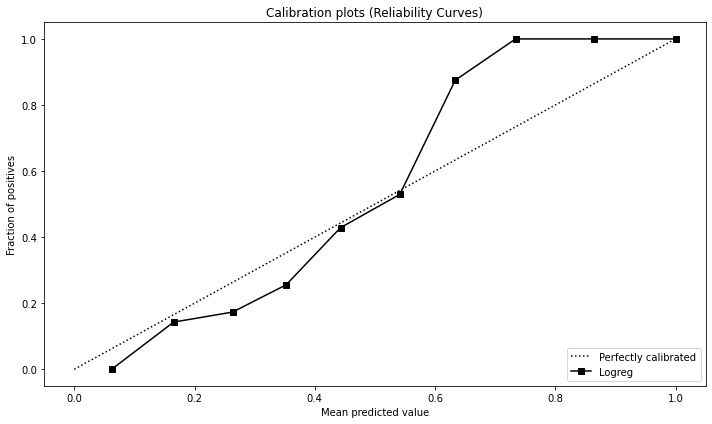

In [10]:
fig = skplt.metrics.plot_calibration_curve(y_test, [y_proba], figsize=(10,6), clf_names=["Logreg"])
plt.tight_layout()
plt.savefig('plots/step8_logreg_uncalibrated.png', dpi=300, bbox_inches='tight')
plt.show()

squared_error_uncalibrated = sum((fig.get_lines()[1].get_xdata() - fig.get_lines()[1].get_ydata())**2)

labels.append("LogReg")
errors_uncalibrated.append(squared_error_uncalibrated)

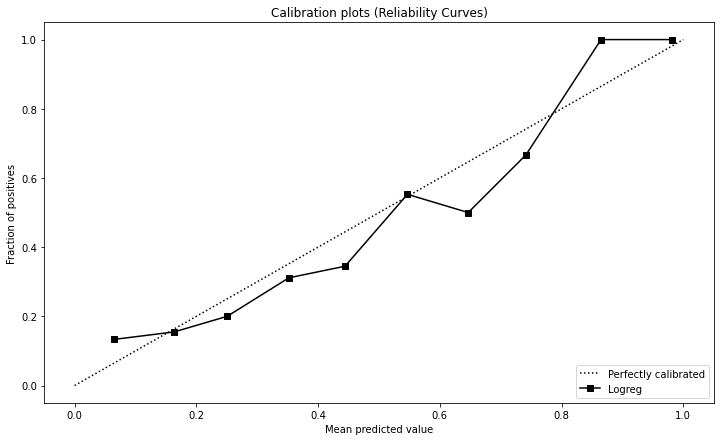

In [11]:
test_model = LogisticRegression(max_iter=5000, **logreg_cv.best_params_)
calibrated_clf = CalibratedClassifierCV(base_estimator=test_model, cv=3, method="sigmoid")

calibrated_clf.fit(X_resampled_logreg, y_resampled)

y_pred = calibrated_clf.predict(X_test_logreg)
y_proba = calibrated_clf.predict_proba(X_test_logreg)

fig = skplt.metrics.plot_calibration_curve(y_test, [y_proba], figsize=(12,7), clf_names=["Logreg"])

squared_error_sigmoid = sum((fig.get_lines()[1].get_xdata() - fig.get_lines()[1].get_ydata())**2)
errors_sigmoid.append(squared_error_sigmoid)
plt.show()

df_scores.loc["logistic_regression_platt"] = [round(end - start, 2),
                                        accuracy_score(y_test, y_pred),
                                        precision_score(y_test, y_pred),
                                        recall_score(y_test, y_pred),
                                        f1_score(y_test, y_pred),
                                        roc_auc_score(y_test, y_proba[:,1])]

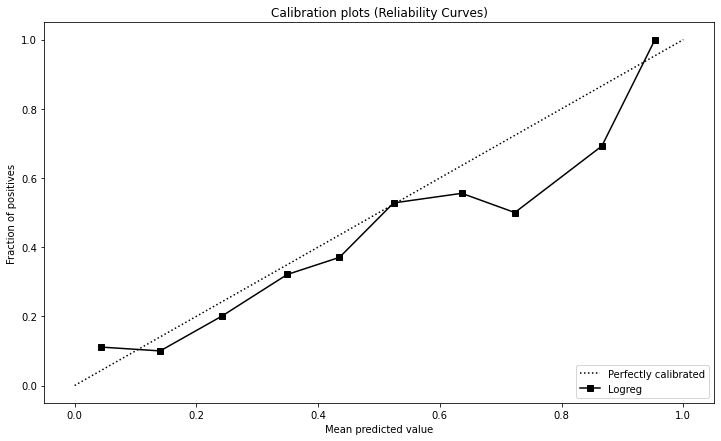

In [12]:
test_model = LogisticRegression(max_iter=5000, **logreg_cv.best_params_)
calibrated_clf = CalibratedClassifierCV(base_estimator=test_model, cv=3, method="isotonic")

calibrated_clf.fit(X_resampled_logreg, y_resampled)

y_pred = calibrated_clf.predict(X_test_logreg)
y_proba = calibrated_clf.predict_proba(X_test_logreg)

fig = skplt.metrics.plot_calibration_curve(y_test, [y_proba], figsize=(12,7), clf_names=["Logreg"])

squared_error_isotonic = sum((fig.get_lines()[1].get_xdata() - fig.get_lines()[1].get_ydata())**2)
errors_isotonic.append(squared_error_isotonic)
plt.show()

df_scores.loc["logistic_regression_isotonic"] = [round(end - start, 2),
                                        accuracy_score(y_test, y_pred),
                                        precision_score(y_test, y_pred),
                                        recall_score(y_test, y_pred),
                                        f1_score(y_test, y_pred),
                                        roc_auc_score(y_test, y_proba[:,1])]

## 2. Naive Bayes

In [61]:
X = df.drop(["wont_renew", "chapter_ID"], axis=1).copy()
y = df["wont_renew"].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=710)

under_sampler = TomekLinks()
X_resampled, y_resampled = under_sampler.fit_resample(X_train, y_train)

scaler = StandardScaler()
scaler.fit(X_resampled)
X_resampled = pd.DataFrame(scaler.transform(X_resampled), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

pca = PCA(n_components=10)
pca.fit(X)
X_resampled = pd.DataFrame(pca.transform(X_resampled))
X_test = pd.DataFrame(pca.transform(X_test))
# print(pca.explained_variance_ratio_)

In [62]:
naive_bayes = GaussianNB()

start = time.time()
naive_bayes.fit(X_resampled, y_resampled)
end = time.time()
print(f"Elapsed time: {(end - start):.2f} seconds")

y_pred = naive_bayes.predict(X_test)
y_proba = naive_bayes.predict_proba(X_test)

df_scores.loc["naive_bayes"] = [round(end - start, 2),
                                        accuracy_score(y_test, y_pred),
                                        precision_score(y_test, y_pred),
                                        recall_score(y_test, y_pred),
                                        f1_score(y_test, y_pred),
                                        roc_auc_score(y_test, y_proba[:,1])]

Elapsed time: 0.00 seconds


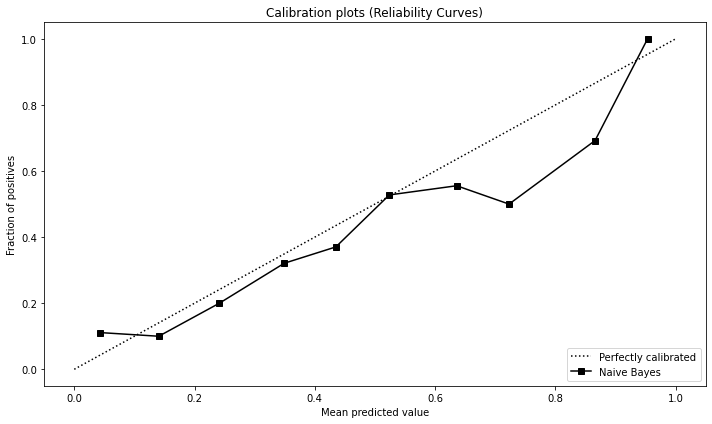

In [15]:
fig = skplt.metrics.plot_calibration_curve(y_test, [y_proba], figsize=(10,6), clf_names=["Naive Bayes"])
plt.tight_layout()
plt.savefig('plots/step8_NB_uncalibrated.png', dpi=300, bbox_inches='tight')
plt.show()

squared_error_uncalibrated = sum((fig.get_lines()[1].get_xdata() - fig.get_lines()[1].get_ydata())**2)

labels.append("NB")
errors_uncalibrated.append(squared_error_uncalibrated)

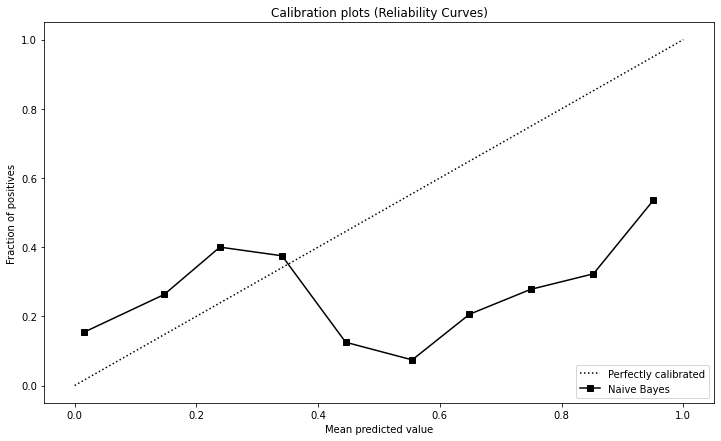

C:\Users\davem\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
test_model = GaussianNB()
calibrated_clf = CalibratedClassifierCV(base_estimator=test_model, cv=3, method="sigmoid")

calibrated_clf.fit(X_resampled, y_resampled)

y_pred = calibrated_clf.predict(X_test)
y_proba = calibrated_clf.predict_proba(X_test)

fig = skplt.metrics.plot_calibration_curve(y_test, [y_proba], figsize=(12,7), clf_names=["Naive Bayes"])

squared_error_sigmoid = sum((fig.get_lines()[1].get_xdata() - fig.get_lines()[1].get_ydata())**2)
errors_sigmoid.append(squared_error_sigmoid)
plt.show()

df_scores.loc["naive_bayes_platt"] = [round(end - start, 2),
                                        accuracy_score(y_test, y_pred),
                                        precision_score(y_test, y_pred),
                                        recall_score(y_test, y_pred),
                                        f1_score(y_test, y_pred),
                                        roc_auc_score(y_test, y_proba[:,1])]

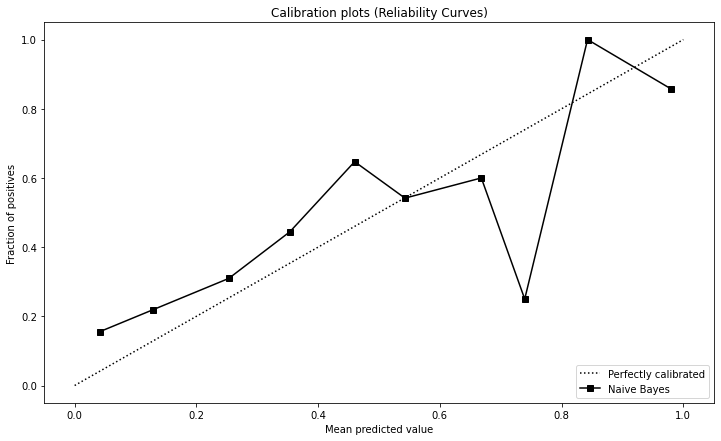

In [17]:
test_model = GaussianNB()
calibrated_clf = CalibratedClassifierCV(base_estimator=test_model, cv=3, method="isotonic")

calibrated_clf.fit(X_resampled, y_resampled)

y_pred = calibrated_clf.predict(X_test)
y_proba = calibrated_clf.predict_proba(X_test)

fig = skplt.metrics.plot_calibration_curve(y_test, [y_proba], figsize=(12,7), clf_names=["Naive Bayes"])

squared_error_isotonic = sum((fig.get_lines()[1].get_xdata() - fig.get_lines()[1].get_ydata())**2)
errors_isotonic.append(squared_error_isotonic)
plt.show()

df_scores.loc["naive_bayes_isotonic"] = [round(end - start, 2),
                                        accuracy_score(y_test, y_pred),
                                        precision_score(y_test, y_pred),
                                        recall_score(y_test, y_pred),
                                        f1_score(y_test, y_pred),
                                        roc_auc_score(y_test, y_proba[:,1])]

## 3. K-neighbors classifier

In [18]:
X = df.drop(["wont_renew", "chapter_ID"], axis=1).copy()
y = df["wont_renew"].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=710)

under_sampler = TomekLinks()
X_resampled, y_resampled = under_sampler.fit_resample(X_train, y_train)

scaler = StandardScaler()
scaler.fit(X_resampled)
X_resampled = pd.DataFrame(scaler.transform(X_resampled), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

pca = PCA(n_components=10)
pca.fit(X)
X_resampled = pd.DataFrame(pca.transform(X_resampled))
X_test = pd.DataFrame(pca.transform(X_test))
# print(pca.explained_variance_ratio_)

In [19]:
knn = KNeighborsClassifier()

knn_grid = {}
knn_grid["n_neighbors"] = [x for x in range(3,20,2)]
knn_grid["weights"] = ["uniform", "distance"]
knn_grid["leaf_size"] = [x for x in range(5,55,5)]

knn_cv = GridSearchCV(knn, knn_grid, scoring="roc_auc", n_jobs=-1, cv=3)

start = time.time()
knn_cv.fit(X_resampled, y_resampled)
end = time.time()
print(f"Elapsed time: {(end - start):.2f} seconds")
print(knn_cv.best_params_)

y_pred = knn_cv.predict(X_test)
y_proba = knn_cv.predict_proba(X_test)

df_scores.loc["knn"] = [round(end - start, 2),
                                        accuracy_score(y_test, y_pred),
                                        precision_score(y_test, y_pred),
                                        recall_score(y_test, y_pred),
                                        f1_score(y_test, y_pred),
                                        roc_auc_score(y_test, y_proba[:,1])]

Elapsed time: 1.86 seconds
{'leaf_size': 5, 'n_neighbors': 19, 'weights': 'distance'}


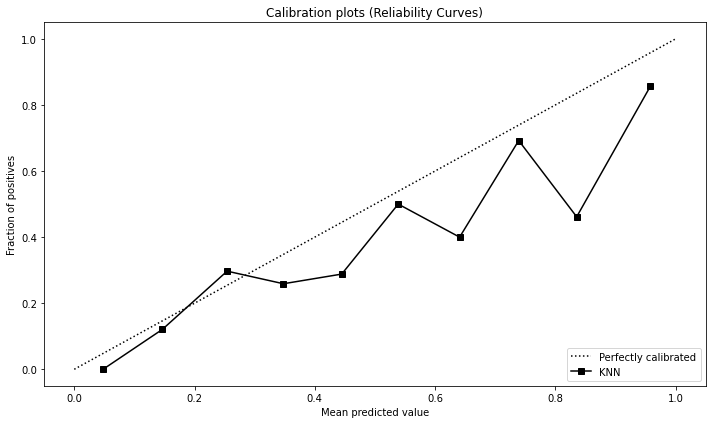

In [20]:
fig = skplt.metrics.plot_calibration_curve(y_test, [y_proba], figsize=(10,6), clf_names=["KNN"])
plt.tight_layout()
plt.savefig('plots/step8_KNN_uncalibrated.png', dpi=300, bbox_inches='tight')
plt.show()

squared_error_uncalibrated = sum((fig.get_lines()[1].get_xdata() - fig.get_lines()[1].get_ydata())**2)

labels.append("KNN")
errors_uncalibrated.append(squared_error_uncalibrated)

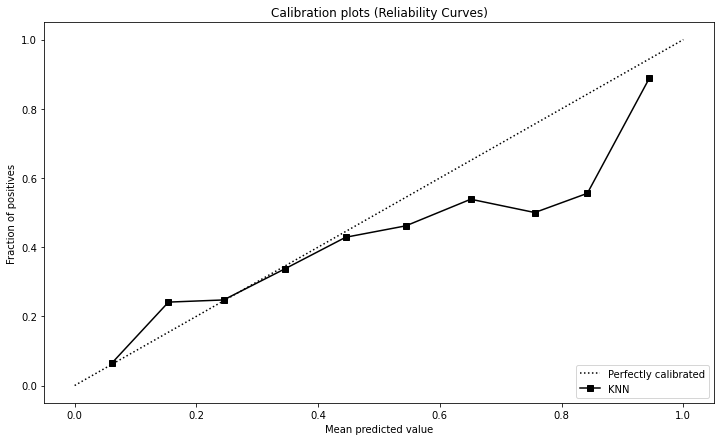

In [21]:
test_model = KNeighborsClassifier(**knn_cv.best_params_)
calibrated_clf = CalibratedClassifierCV(base_estimator=test_model, cv=3, method="sigmoid")

calibrated_clf.fit(X_resampled, y_resampled)

y_pred = calibrated_clf.predict(X_test)
y_proba = calibrated_clf.predict_proba(X_test)

fig = skplt.metrics.plot_calibration_curve(y_test, [y_proba], figsize=(12,7), clf_names=["KNN"])

squared_error_sigmoid = sum((fig.get_lines()[1].get_xdata() - fig.get_lines()[1].get_ydata())**2)
errors_sigmoid.append(squared_error_sigmoid)
plt.show()

df_scores.loc["knn_platt"] = [round(end - start, 2),
                                        accuracy_score(y_test, y_pred),
                                        precision_score(y_test, y_pred),
                                        recall_score(y_test, y_pred),
                                        f1_score(y_test, y_pred),
                                        roc_auc_score(y_test, y_proba[:,1])]

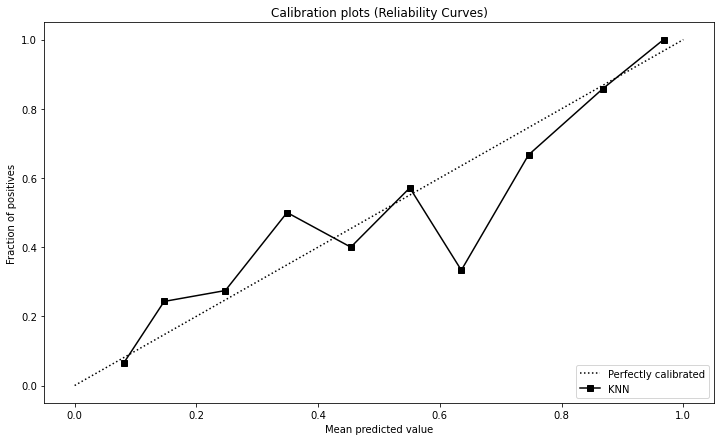

In [22]:
test_model = KNeighborsClassifier(**knn_cv.best_params_)
calibrated_clf = CalibratedClassifierCV(base_estimator=test_model, cv=3, method="isotonic")

calibrated_clf.fit(X_resampled, y_resampled)

y_pred = calibrated_clf.predict(X_test)
y_proba = calibrated_clf.predict_proba(X_test)

fig = skplt.metrics.plot_calibration_curve(y_test, [y_proba], figsize=(12,7), clf_names=["KNN"])

squared_error_isotonic = sum((fig.get_lines()[1].get_xdata() - fig.get_lines()[1].get_ydata())**2)
errors_isotonic.append(squared_error_isotonic)
plt.show()

df_scores.loc["knn_isotonic"] = [round(end - start, 2),
                                        accuracy_score(y_test, y_pred),
                                        precision_score(y_test, y_pred),
                                        recall_score(y_test, y_pred),
                                        f1_score(y_test, y_pred),
                                        roc_auc_score(y_test, y_proba[:,1])]

## 4. Decision Tree

In [23]:
X = df.drop(["wont_renew", "chapter_ID"], axis=1).copy()
y = df["wont_renew"].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=710)

under_sampler = TomekLinks()
X_resampled, y_resampled = under_sampler.fit_resample(X_train, y_train)

scaler = StandardScaler()
scaler.fit(X_resampled)
X_resampled = pd.DataFrame(scaler.transform(X_resampled), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

In [24]:
dt = DecisionTreeClassifier()

X_resampled_dt = X_resampled[dt_10_features]
X_test_dt = X_test[dt_10_features]

dt_grid = {}
dt_grid["max_depth"] = [x for x in range(2, 51, 2)]
dt_grid["min_samples_split"] = [x for x in range(2, 11, 2)]
dt_grid["min_samples_leaf"] = [x for x in range(1, 8, 1)]

dt_cv = GridSearchCV(dt, dt_grid, scoring="roc_auc", n_jobs=-1, cv=3, verbose=2)

start = time.time()
dt_cv.fit(X_resampled_dt, y_resampled)
end = time.time()
print(f"Elapsed time: {(end - start):.2f} seconds")
print(dt_cv.best_params_)

y_pred = dt_cv.predict(X_test_dt)
y_proba = dt_cv.predict_proba(X_test_dt)

df_scores.loc["decision_tree"] = [round(end - start, 2),
                                        accuracy_score(y_test, y_pred),
                                        precision_score(y_test, y_pred),
                                        recall_score(y_test, y_pred),
                                        f1_score(y_test, y_pred),
                                        roc_auc_score(y_test, y_proba[:,1])]

Fitting 3 folds for each of 875 candidates, totalling 2625 fits
Elapsed time: 4.33 seconds
{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}


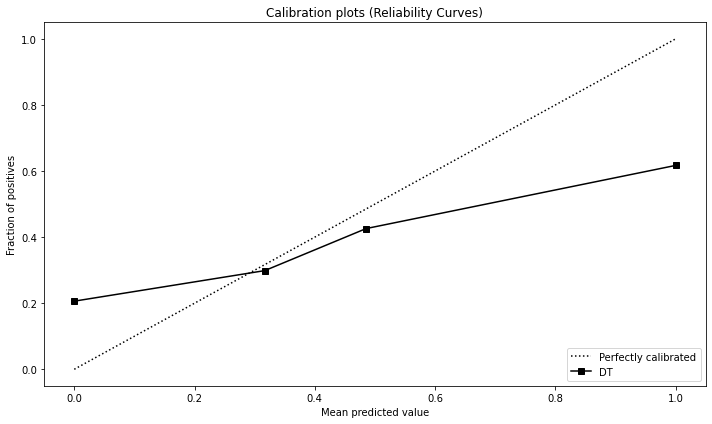

In [25]:
fig = skplt.metrics.plot_calibration_curve(y_test, [y_proba], figsize=(10,6), clf_names=["DT"])
plt.tight_layout()
plt.savefig('plots/step8_DT_uncalibrated.png', dpi=300, bbox_inches='tight')
plt.show()

squared_error_uncalibrated = sum((fig.get_lines()[1].get_xdata() - fig.get_lines()[1].get_ydata())**2)

labels.append("DT")
errors_uncalibrated.append(squared_error_uncalibrated)

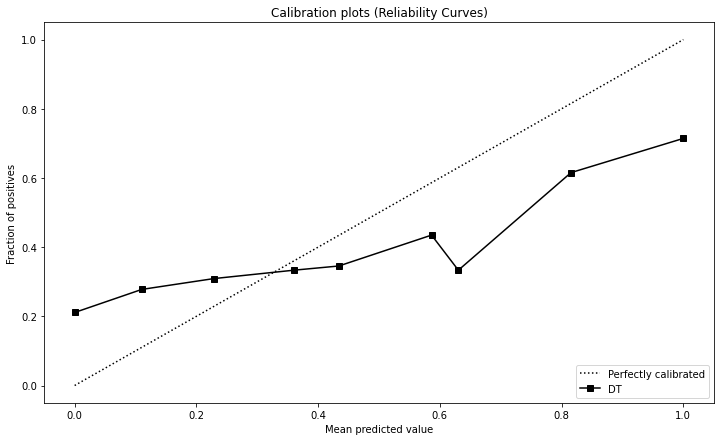

In [26]:
test_model = DecisionTreeClassifier(**dt_cv.best_params_)
calibrated_clf = CalibratedClassifierCV(base_estimator=test_model, cv=3, method="sigmoid")

calibrated_clf.fit(X_resampled_dt, y_resampled)

y_pred = calibrated_clf.predict(X_test_dt)
y_proba = calibrated_clf.predict_proba(X_test_dt)

fig = skplt.metrics.plot_calibration_curve(y_test, [y_proba], figsize=(12,7), clf_names=["DT"])

squared_error_sigmoid = sum((fig.get_lines()[1].get_xdata() - fig.get_lines()[1].get_ydata())**2)
errors_sigmoid.append(squared_error_sigmoid)
plt.show()

df_scores.loc["decision_tree_platt"] = [round(end - start, 2),
                                        accuracy_score(y_test, y_pred),
                                        precision_score(y_test, y_pred),
                                        recall_score(y_test, y_pred),
                                        f1_score(y_test, y_pred),
                                        roc_auc_score(y_test, y_proba[:,1])]

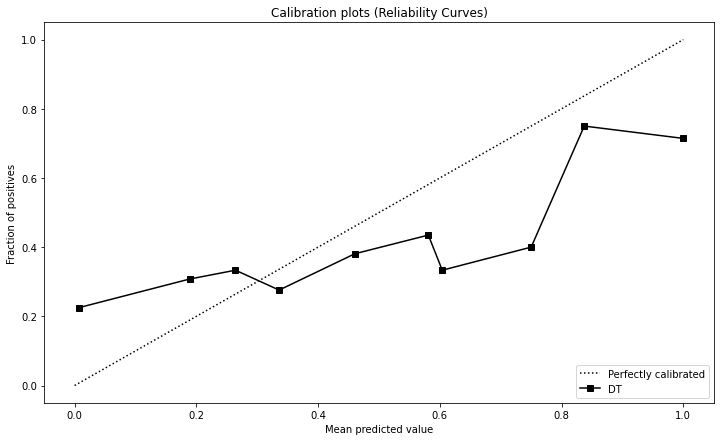

In [27]:
test_model = DecisionTreeClassifier(**dt_cv.best_params_)
calibrated_clf = CalibratedClassifierCV(base_estimator=test_model, cv=3, method="isotonic")

calibrated_clf.fit(X_resampled_dt, y_resampled)

y_pred = calibrated_clf.predict(X_test_dt)
y_proba = calibrated_clf.predict_proba(X_test_dt)

fig = skplt.metrics.plot_calibration_curve(y_test, [y_proba], figsize=(12,7), clf_names=["DT"])

squared_error_isotonic = sum((fig.get_lines()[1].get_xdata() - fig.get_lines()[1].get_ydata())**2)
errors_isotonic.append(squared_error_isotonic)
plt.show()

df_scores.loc["decision_tree_isotonic"] = [round(end - start, 2),
                                        accuracy_score(y_test, y_pred),
                                        precision_score(y_test, y_pred),
                                        recall_score(y_test, y_pred),
                                        f1_score(y_test, y_pred),
                                        roc_auc_score(y_test, y_proba[:,1])]

## 5. Random Forest

In [11]:
X = df.drop(["wont_renew", "chapter_ID"], axis=1).copy()
y = df["wont_renew"].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=710)

under_sampler = TomekLinks()
X_resampled, y_resampled = under_sampler.fit_resample(X_train, y_train)

scaler = StandardScaler()
scaler.fit(X_resampled)
X_resampled = pd.DataFrame(scaler.transform(X_resampled), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

In [12]:
rf = RandomForestClassifier()

X_resampled_rf = X_resampled[rf_10_features]
X_test_rf = X_test[rf_10_features]

rf_grid = {}
rf_grid["n_estimators"] = [50, 100, 200, 400]
rf_grid["max_depth"] = [x for x in range(2, 10, 2)]
rf_grid["min_samples_split"] = [x for x in range(2, 7, 2)]
rf_grid["min_samples_leaf"] = [x for x in range(1, 6, 1)]

rf_cv = GridSearchCV(rf, rf_grid, scoring="roc_auc", n_jobs=-1, cv=3, verbose=2)

start = time.time()
rf_cv.fit(X_resampled_rf, y_resampled)
end = time.time()
print(f"Elapsed time: {(end - start):.2f} seconds")
print(rf_cv.best_params_)

y_pred = rf_cv.predict(X_test_rf)
y_proba = rf_cv.predict_proba(X_test_rf)

df_scores.loc["random_forest"] = [round(end - start, 2),
                                        accuracy_score(y_test, y_pred),
                                        precision_score(y_test, y_pred),
                                        recall_score(y_test, y_pred),
                                        f1_score(y_test, y_pred),
                                        roc_auc_score(y_test, y_proba[:,1])]

Fitting 3 folds for each of 240 candidates, totalling 720 fits
Elapsed time: 55.40 seconds
{'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


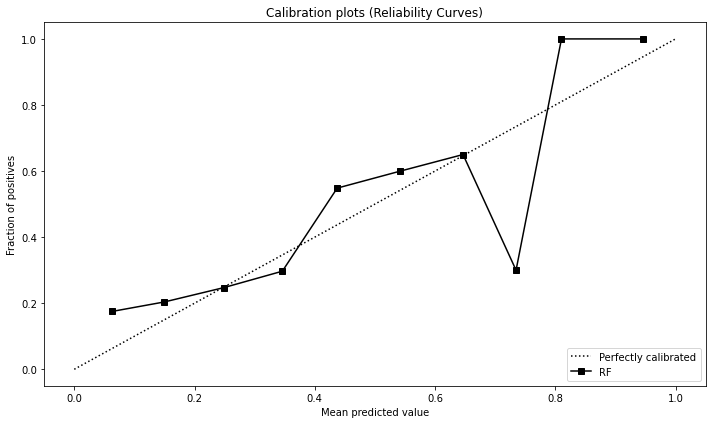

In [30]:
fig = skplt.metrics.plot_calibration_curve(y_test, [y_proba], figsize=(10,6), clf_names=["RF"])
plt.tight_layout()
plt.savefig('plots/step8_RF_uncalibrated.png', dpi=300, bbox_inches='tight')
plt.show()

squared_error_uncalibrated = sum((fig.get_lines()[1].get_xdata() - fig.get_lines()[1].get_ydata())**2)

labels.append("RF")
errors_uncalibrated.append(squared_error_uncalibrated)

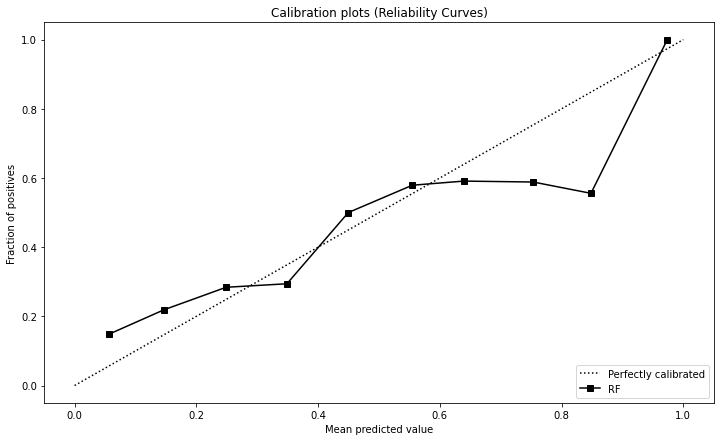

In [31]:
test_model = RandomForestClassifier(**rf_cv.best_params_)
calibrated_clf = CalibratedClassifierCV(base_estimator=test_model, cv=3, method="sigmoid")

calibrated_clf.fit(X_resampled_rf, y_resampled)

y_pred = calibrated_clf.predict(X_test_rf)
y_proba = calibrated_clf.predict_proba(X_test_rf)

fig = skplt.metrics.plot_calibration_curve(y_test, [y_proba], figsize=(12,7), clf_names=["RF"])

squared_error_sigmoid = sum((fig.get_lines()[1].get_xdata() - fig.get_lines()[1].get_ydata())**2)
errors_sigmoid.append(squared_error_sigmoid)
plt.show()

df_scores.loc["random_forest_platt"] = [round(end - start, 2),
                                        accuracy_score(y_test, y_pred),
                                        precision_score(y_test, y_pred),
                                        recall_score(y_test, y_pred),
                                        f1_score(y_test, y_pred),
                                        roc_auc_score(y_test, y_proba[:,1])]

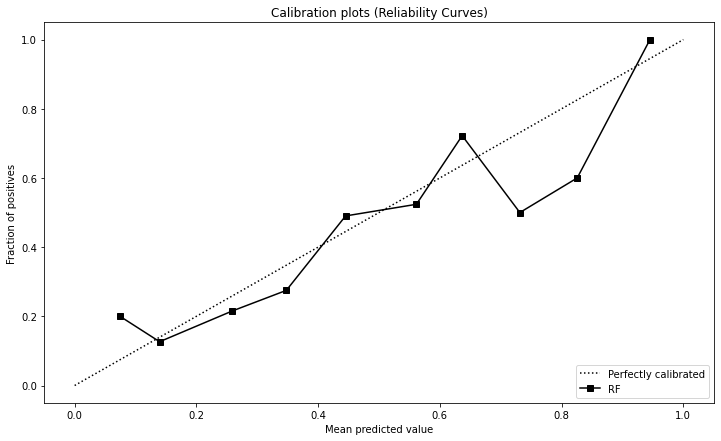

In [32]:
test_model = RandomForestClassifier(**rf_cv.best_params_)
calibrated_clf = CalibratedClassifierCV(base_estimator=test_model, cv=3, method="isotonic")

calibrated_clf.fit(X_resampled_rf, y_resampled)

y_pred = calibrated_clf.predict(X_test_rf)
y_proba = calibrated_clf.predict_proba(X_test_rf)

fig = skplt.metrics.plot_calibration_curve(y_test, [y_proba], figsize=(12,7), clf_names=["RF"])

squared_error_isotonic = sum((fig.get_lines()[1].get_xdata() - fig.get_lines()[1].get_ydata())**2)
errors_isotonic.append(squared_error_isotonic)
plt.show()

df_scores.loc["random_forest_isotonic"] = [round(end - start, 2),
                                        accuracy_score(y_test, y_pred),
                                        precision_score(y_test, y_pred),
                                        recall_score(y_test, y_pred),
                                        f1_score(y_test, y_pred),
                                        roc_auc_score(y_test, y_proba[:,1])]

## 6. AdaBoost

In [33]:
X = df.drop(["wont_renew", "chapter_ID"], axis=1).copy()
y = df["wont_renew"].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=710)

under_sampler = TomekLinks()
X_resampled, y_resampled = under_sampler.fit_resample(X_train, y_train)

scaler = StandardScaler()
scaler.fit(X_resampled)
X_resampled = pd.DataFrame(scaler.transform(X_resampled), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

In [34]:
ada = AdaBoostClassifier()

X_resampled_ada = X_resampled[ada_10_features]
X_test_ada = X_test[ada_10_features]

ada_grid = {}
ada_grid["n_estimators"] = [50, 100, 200, 400]
ada_grid["learning_rate"] = [0.03, 0.1, 0.3, 1]

ada_cv = GridSearchCV(ada, ada_grid, scoring="roc_auc", n_jobs=-1, cv=3, verbose=2)

start = time.time()
ada_cv.fit(X_resampled_ada, y_resampled)
end = time.time()
print(f"Elapsed time: {(end - start):.2f} seconds")
print(ada_cv.best_params_)

y_pred = ada_cv.predict(X_test_ada)
y_proba = ada_cv.predict_proba(X_test_ada)

df_scores.loc["AdaBoost"] = [round(end - start, 2),
                                        accuracy_score(y_test, y_pred),
                                        precision_score(y_test, y_pred),
                                        recall_score(y_test, y_pred),
                                        f1_score(y_test, y_pred),
                                        roc_auc_score(y_test, y_proba[:,1])]

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Elapsed time: 4.78 seconds
{'learning_rate': 0.1, 'n_estimators': 200}


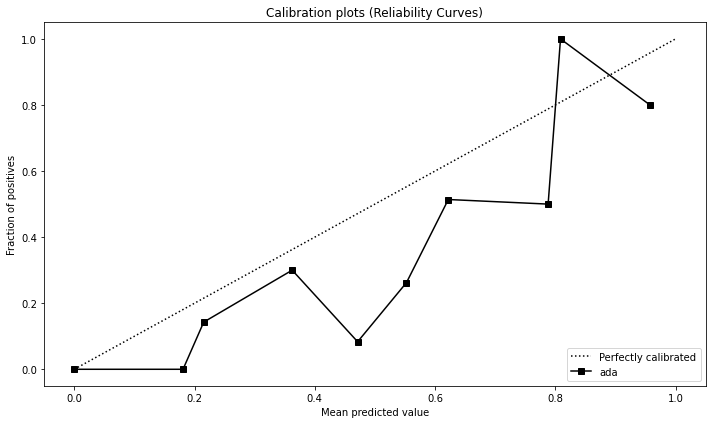

In [35]:
fig = skplt.metrics.plot_calibration_curve(y_test, [y_proba], figsize=(10,6), clf_names=["ada"])
plt.tight_layout()
plt.savefig('plots/step8_ada_uncalibrated.png', dpi=300, bbox_inches='tight')
plt.show()

squared_error_uncalibrated = sum((fig.get_lines()[1].get_xdata() - fig.get_lines()[1].get_ydata())**2)

labels.append("AdaBoost")
errors_uncalibrated.append(squared_error_uncalibrated)

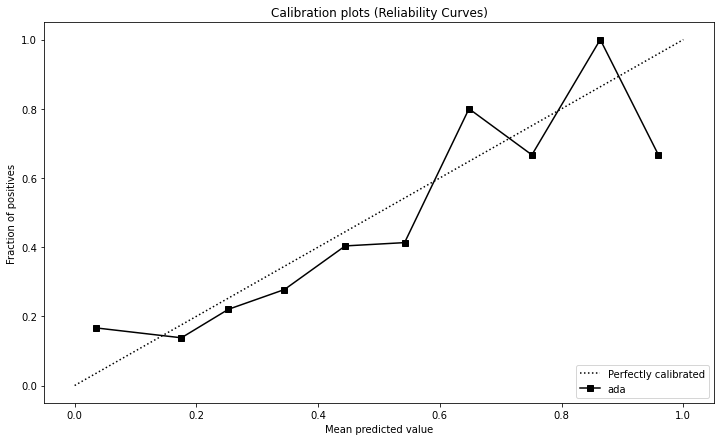

In [36]:
test_model = AdaBoostClassifier(**ada_cv.best_params_)
calibrated_clf = CalibratedClassifierCV(base_estimator=test_model, cv=3, method="sigmoid")

calibrated_clf.fit(X_resampled_ada, y_resampled)

y_pred = calibrated_clf.predict(X_test_ada)
y_proba = calibrated_clf.predict_proba(X_test_ada)

fig = skplt.metrics.plot_calibration_curve(y_test, [y_proba], figsize=(12,7), clf_names=["ada"])

squared_error_sigmoid = sum((fig.get_lines()[1].get_xdata() - fig.get_lines()[1].get_ydata())**2)
errors_sigmoid.append(squared_error_sigmoid)
plt.show()

df_scores.loc["AdaBoost_platt"] = [round(end - start, 2),
                                        accuracy_score(y_test, y_pred),
                                        precision_score(y_test, y_pred),
                                        recall_score(y_test, y_pred),
                                        f1_score(y_test, y_pred),
                                        roc_auc_score(y_test, y_proba[:,1])]

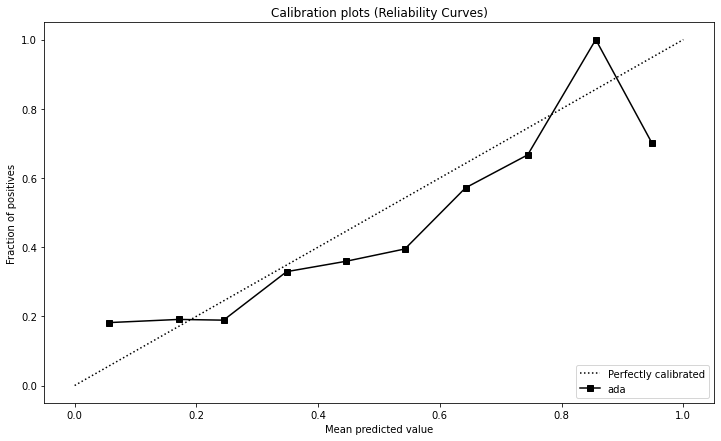

In [37]:
test_model = AdaBoostClassifier(**ada_cv.best_params_)
calibrated_clf = CalibratedClassifierCV(base_estimator=test_model, cv=3, method="isotonic")

calibrated_clf.fit(X_resampled_ada, y_resampled)

y_pred = calibrated_clf.predict(X_test_ada)
y_proba = calibrated_clf.predict_proba(X_test_ada)

fig = skplt.metrics.plot_calibration_curve(y_test, [y_proba], figsize=(12,7), clf_names=["ada"])

squared_error_isotonic = sum((fig.get_lines()[1].get_xdata() - fig.get_lines()[1].get_ydata())**2)
errors_isotonic.append(squared_error_isotonic)
plt.show()

df_scores.loc["AdaBoost_isotonic"] = [round(end - start, 2),
                                        accuracy_score(y_test, y_pred),
                                        precision_score(y_test, y_pred),
                                        recall_score(y_test, y_pred),
                                        f1_score(y_test, y_pred),
                                        roc_auc_score(y_test, y_proba[:,1])]

## 7. XGBoost

In [13]:
X = df.drop(["wont_renew", "chapter_ID"], axis=1).copy()
y = df["wont_renew"].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=710)

under_sampler = TomekLinks()
X_resampled, y_resampled = under_sampler.fit_resample(X_train, y_train)

scaler = StandardScaler()
scaler.fit(X_resampled)
X_resampled = pd.DataFrame(scaler.transform(X_resampled), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

In [14]:
xg = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc", random_state=42, use_label_encoder=False)

X_resampled_xgb = X_resampled[xgb_10_features]
X_test_xgb = X_test[xgb_10_features]

xg_grid = {}
xg_grid["n_estimators"] = [50, 100, 200, 400]
xg_grid["colsample_bytree"] = [0.1, 0.3, 0.5, 0.8]
xg_grid["learning_rate"] = [0.03, 0.1, 0.3, 1]
xg_grid["max_depth"] = [x for x in range(2, 11, 1)]
xg_grid["alpha"] = [0.1, 0.3, 1, 3, 10]

xg_cv = GridSearchCV(xg, xg_grid, scoring="roc_auc", n_jobs=-1, cv=3, verbose=2)

start = time.time()
xg_cv.fit(X_resampled_xgb, y_resampled)
end = time.time()
print(f"Elapsed time: {(end - start):.2f} seconds")
print(xg_cv.best_params_)

y_pred = xg_cv.predict(X_test_xgb)
y_proba = xg_cv.predict_proba(X_test_xgb)

df_scores.loc["XGBoost"] = [round(end - start, 2),
                                        accuracy_score(y_test, y_pred),
                                        precision_score(y_test, y_pred),
                                        recall_score(y_test, y_pred),
                                        f1_score(y_test, y_pred),
                                        roc_auc_score(y_test, y_proba[:,1])]

Fitting 3 folds for each of 2880 candidates, totalling 8640 fits
Elapsed time: 299.89 seconds
{'alpha': 3, 'colsample_bytree': 0.1, 'learning_rate': 0.03, 'max_depth': 2, 'n_estimators': 50}


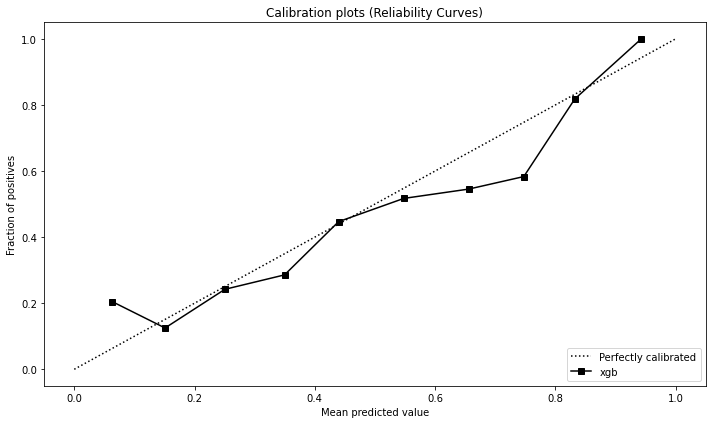

In [40]:
fig = skplt.metrics.plot_calibration_curve(y_test, [y_proba], figsize=(10,6), clf_names=["xgb"])
plt.tight_layout()
plt.savefig('plots/step8_xgb_uncalibrated.png', dpi=300, bbox_inches='tight')
plt.show()

squared_error_uncalibrated = sum((fig.get_lines()[1].get_xdata() - fig.get_lines()[1].get_ydata())**2)

labels.append("XGBoost")
errors_uncalibrated.append(squared_error_uncalibrated)

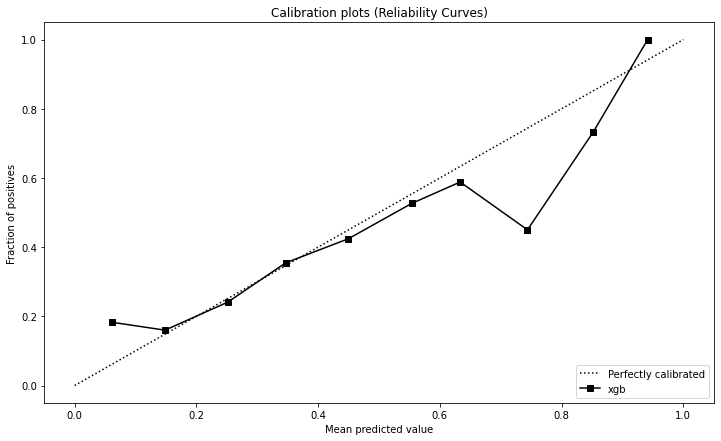

In [41]:
test_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc", random_state=42, use_label_encoder=False, **xg_cv.best_params_)
calibrated_clf = CalibratedClassifierCV(base_estimator=test_model, cv=3, method="sigmoid")

calibrated_clf.fit(X_resampled_xgb, y_resampled)

y_pred = calibrated_clf.predict(X_test_xgb)
y_proba = calibrated_clf.predict_proba(X_test_xgb)

fig = skplt.metrics.plot_calibration_curve(y_test, [y_proba], figsize=(12,7), clf_names=["xgb"])

squared_error_sigmoid = sum((fig.get_lines()[1].get_xdata() - fig.get_lines()[1].get_ydata())**2)
errors_sigmoid.append(squared_error_sigmoid)
plt.savefig('plots/step8_xgb_platt.png', dpi=300, bbox_inches='tight')
plt.show()

df_scores.loc["XGBoost_platt"] = [round(end - start, 2),
                                        accuracy_score(y_test, y_pred),
                                        precision_score(y_test, y_pred),
                                        recall_score(y_test, y_pred),
                                        f1_score(y_test, y_pred),
                                        roc_auc_score(y_test, y_proba[:,1])]

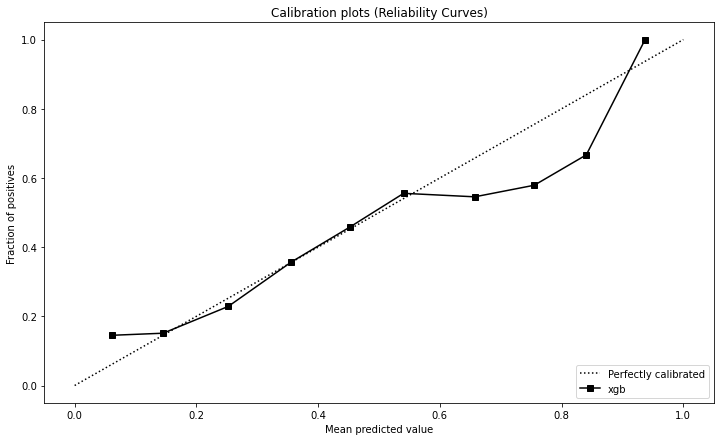

In [42]:
test_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc", random_state=42, use_label_encoder=False, **xg_cv.best_params_)
calibrated_clf = CalibratedClassifierCV(base_estimator=test_model, cv=3, method="isotonic")

calibrated_clf.fit(X_resampled_xgb, y_resampled)

y_pred = calibrated_clf.predict(X_test_xgb)
y_proba = calibrated_clf.predict_proba(X_test_xgb)

fig = skplt.metrics.plot_calibration_curve(y_test, [y_proba], figsize=(12,7), clf_names=["xgb"])

squared_error_isotonic = sum((fig.get_lines()[1].get_xdata() - fig.get_lines()[1].get_ydata())**2)
errors_isotonic.append(squared_error_isotonic)
plt.savefig('plots/step8_xgb_isotonic.png', dpi=300, bbox_inches='tight')
plt.show()

df_scores.loc["XGBoost_isotonic"] = [round(end - start, 2),
                                        accuracy_score(y_test, y_pred),
                                        precision_score(y_test, y_pred),
                                        recall_score(y_test, y_pred),
                                        f1_score(y_test, y_pred),
                                        roc_auc_score(y_test, y_proba[:,1])]

## 8. CatBoost

In [43]:
X = df.drop(["wont_renew"], axis=1).copy()
y = df["wont_renew"].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=710)

cb = CatBoostClassifier(early_stopping_rounds=20, eval_metric="AUC", verbose=0, cat_features=["chapter_ID"])

X_train_cat = X_train[catboost_10_features]
X_test_cat = X_test[catboost_10_features]

cb_grid = {}
cb_grid["iterations"] = [50, 100, 200, 400]
cb_grid["learning_rate"] = [0.03, 0.1, 0.3, 1]
cb_grid['l2_leaf_reg'] = [1, 3, 5, 7, 9]
cb_grid["depth"] = [4, 6, 8, 10]

start = time.time()
grid_search_result = cb.grid_search(cb_grid, X=X_train_cat, y=y_train, plot=False)
end = time.time()
print(f"Elapsed time: {(end - start):.2f} seconds")
print(grid_search_result["params"])

y_pred = cb.predict(X_test_cat)
y_proba = cb.predict_proba(X_test_cat)
df_scores.loc["CatBoost"] = [round(end - start, 2),
                                        accuracy_score(y_test, y_pred),
                                        precision_score(y_test, y_pred),
                                        recall_score(y_test, y_pred),
                                        f1_score(y_test, y_pred),
                                        roc_auc_score(y_test, y_proba[:,1])]


bestTest = 0.6937004904
bestIteration = 46

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	loss: 0.6937005	best: 0.6937005 (0)	total: 1.2s	remaining: 6m 24s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6889098453
bestIteration = 15

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
1:	loss: 0.6889098	best: 0.6937005 (0)	total: 1.92s	remaining: 5m 5s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6961523953
bestIteration = 25

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
2:	loss: 0.6961524	best: 0.6961524 (2)	total: 2.9s	remaining: 5m 7s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.667125613
bestIteration = 2

Metric AUC is not calculated on train by default. To

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6858543946
bestIteration = 26

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
28:	loss: 0.6858544	best: 0.7042814 (5)	total: 22.3s	remaining: 3m 44s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6973217654
bestIteration = 46

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
29:	loss: 0.6973218	best: 0.7042814 (5)	total: 23.7s	remaining: 3m 49s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6797812146
bestIteration = 4

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
30:	loss: 0.6797812	best: 0.7042814 (5)	total: 24.2s	remaining: 3m 45s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6721614485
bestIterat

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6870614862
bestIteration = 3

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
55:	loss: 0.6870615	best: 0.7094304 (46)	total: 42.3s	remaining: 3m 19s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.699019238
bestIteration = 6

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
56:	loss: 0.6990192	best: 0.7094304 (46)	total: 43s	remaining: 3m 18s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7010184836
bestIteration = 7

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
57:	loss: 0.7010185	best: 0.7094304 (46)	total: 43.5s	remaining: 3m 16s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7069219163
bestIteratio

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.655771407
bestIteration = 3

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
83:	loss: 0.6557714	best: 0.7094304 (46)	total: 1m	remaining: 2m 49s

bestTest = 0.6867597133
bestIteration = 44

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
84:	loss: 0.6867597	best: 0.7094304 (46)	total: 1m 1s	remaining: 2m 50s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6815918521
bestIteration = 8

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
85:	loss: 0.6815919	best: 0.7094304 (46)	total: 1m 2s	remaining: 2m 51s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6804224821
bestIteration = 7

Metric AUC is not calculated on train by defaul

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6908713693
bestIteration = 63

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
112:	loss: 0.6908714	best: 0.7094304 (46)	total: 1m 37s	remaining: 2m 59s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6927951716
bestIteration = 32

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
113:	loss: 0.6927952	best: 0.7094304 (46)	total: 1m 39s	remaining: 2m 59s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6715956243
bestIteration = 11

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
114:	loss: 0.6715956	best: 0.7094304 (46)	total: 1m 40s	remaining: 2m 59s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6611090155


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6608449642
bestIteration = 5

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
139:	loss: 0.6608450	best: 0.7094304 (46)	total: 2m 18s	remaining: 2m 57s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6909468125
bestIteration = 55

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
140:	loss: 0.6909468	best: 0.7094304 (46)	total: 2m 20s	remaining: 2m 58s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7032817805
bestIteration = 14

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
141:	loss: 0.7032818	best: 0.7094304 (46)	total: 2m 21s	remaining: 2m 57s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6840437571
b

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6493398717
bestIteration = 20

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
167:	loss: 0.6493399	best: 0.7094304 (46)	total: 2m 54s	remaining: 2m 37s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6936250472
bestIteration = 17

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
168:	loss: 0.6936250	best: 0.7094304 (46)	total: 2m 55s	remaining: 2m 36s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6867597133
bestIteration = 23

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
169:	loss: 0.6867597	best: 0.7094304 (46)	total: 2m 57s	remaining: 2m 36s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7032440588


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.667125613
bestIteration = 2

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
195:	loss: 0.6671256	best: 0.7094304 (46)	total: 3m 42s	remaining: 2m 20s

bestTest = 0.6962655602
bestIteration = 93

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
196:	loss: 0.6962656	best: 0.7094304 (46)	total: 3m 47s	remaining: 2m 22s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7003772161
bestIteration = 23

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
197:	loss: 0.7003772	best: 0.7094304 (46)	total: 3m 49s	remaining: 2m 21s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6969068276
bestIteration = 38

Metric AUC is not calculated on trai

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6704262542
bestIteration = 3

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
222:	loss: 0.6704263	best: 0.7190117 (201)	total: 4m 26s	remaining: 1m 55s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6704073934
bestIteration = 1

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
223:	loss: 0.6704074	best: 0.7190117 (201)	total: 4m 27s	remaining: 1m 54s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7064881177
bestIteration = 65

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
224:	loss: 0.7064881	best: 0.7190117 (201)	total: 4m 30s	remaining: 1m 54s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7012825349

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.71565447
bestIteration = 7

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
249:	loss: 0.7156545	best: 0.7345719 (242)	total: 5m 4s	remaining: 1m 25s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7139192757
bestIteration = 12

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
250:	loss: 0.7139193	best: 0.7345719 (242)	total: 5m 5s	remaining: 1m 24s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6847793286
bestIteration = 0

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
251:	loss: 0.6847793	best: 0.7345719 (242)	total: 5m 7s	remaining: 1m 22s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7117314221
best

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7033949453
bestIteration = 7

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
277:	loss: 0.7033949	best: 0.7345719 (242)	total: 5m 50s	remaining: 53s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6944549227
bestIteration = 10

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
278:	loss: 0.6944549	best: 0.7345719 (242)	total: 5m 52s	remaining: 51.7s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6952847982
bestIteration = 38

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
279:	loss: 0.6952848	best: 0.7345719 (242)	total: 5m 55s	remaining: 50.8s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7041870992
bes

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6927197284
bestIteration = 6

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
304:	loss: 0.6927197	best: 0.7345719 (242)	total: 6m 40s	remaining: 19.7s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7044888721
bestIteration = 11

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
305:	loss: 0.7044889	best: 0.7345719 (242)	total: 6m 41s	remaining: 18.4s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6570350811
bestIteration = 19

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
306:	loss: 0.6570351	best: 0.7345719 (242)	total: 6m 44s	remaining: 17.1s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6862693323
b

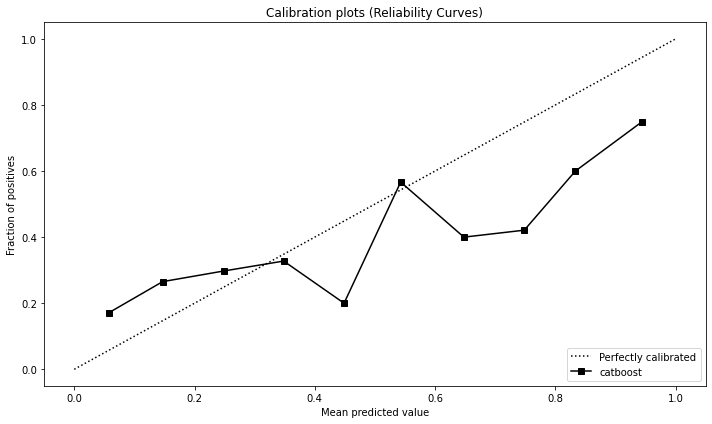

In [44]:
fig = skplt.metrics.plot_calibration_curve(y_test, [y_proba], figsize=(10,6), clf_names=["catboost"])
plt.tight_layout()
plt.savefig('plots/step8_catboost_uncalibrated.png', dpi=300, bbox_inches='tight')
plt.show()

squared_error_uncalibrated = sum((fig.get_lines()[1].get_xdata() - fig.get_lines()[1].get_ydata())**2)

labels.append("CatBoost")
errors_uncalibrated.append(squared_error_uncalibrated)

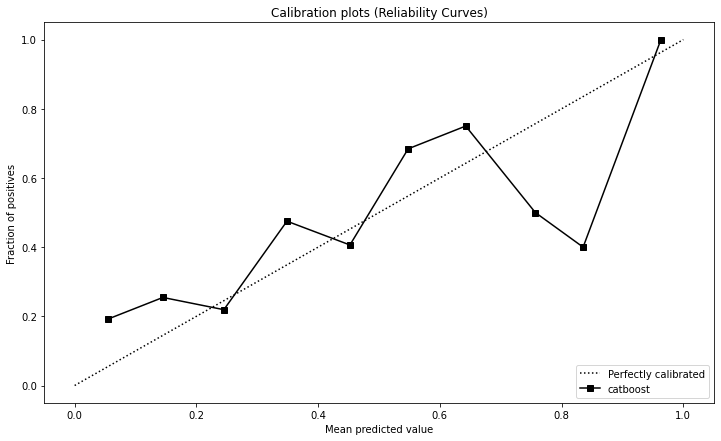

In [45]:
test_model = CatBoostClassifier(early_stopping_rounds=20, eval_metric="AUC", verbose=0, cat_features=["chapter_ID"], **grid_search_result["params"])
calibrated_clf = CalibratedClassifierCV(base_estimator=test_model, cv=3, method="sigmoid")

calibrated_clf.fit(X_train_cat, y_train)

y_pred = calibrated_clf.predict(X_test_cat)
y_proba = calibrated_clf.predict_proba(X_test_cat)

fig = skplt.metrics.plot_calibration_curve(y_test, [y_proba], figsize=(12,7), clf_names=["catboost"])

squared_error_sigmoid = sum((fig.get_lines()[1].get_xdata() - fig.get_lines()[1].get_ydata())**2)
errors_sigmoid.append(squared_error_sigmoid)
plt.show()

df_scores.loc["CatBoost_platt"] = [round(end - start, 2),
                                        accuracy_score(y_test, y_pred),
                                        precision_score(y_test, y_pred),
                                        recall_score(y_test, y_pred),
                                        f1_score(y_test, y_pred),
                                        roc_auc_score(y_test, y_proba[:,1])]

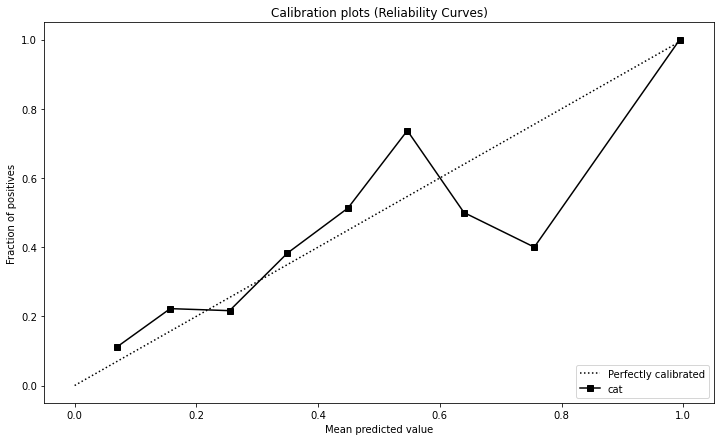

In [46]:
test_model = CatBoostClassifier(early_stopping_rounds=20, eval_metric="AUC", verbose=0, cat_features=["chapter_ID"], **grid_search_result["params"])
calibrated_clf = CalibratedClassifierCV(base_estimator=test_model, cv=3, method="isotonic")

calibrated_clf.fit(X_train_cat, y_train)

y_pred = calibrated_clf.predict(X_test_cat)
y_proba = calibrated_clf.predict_proba(X_test_cat)

fig = skplt.metrics.plot_calibration_curve(y_test, [y_proba], figsize=(12,7), clf_names=["cat"])

squared_error_isotonic = sum((fig.get_lines()[1].get_xdata() - fig.get_lines()[1].get_ydata())**2)
errors_isotonic.append(squared_error_isotonic)
plt.show()

df_scores.loc["CatBoost_isotonic"] = [round(end - start, 2),
                                        accuracy_score(y_test, y_pred),
                                        precision_score(y_test, y_pred),
                                        recall_score(y_test, y_pred),
                                        f1_score(y_test, y_pred),
                                        roc_auc_score(y_test, y_proba[:,1])]

## Compare results

In [63]:
df_scores.sort_values("auc", ascending=False)

,training_time [s],accuracy,precision,recall,f1,auc
XGBoost_isotonic,303.25,0.728929,0.593023,0.377778,0.461538,0.711087
XGBoost_platt,303.25,0.731207,0.607595,0.355556,0.448598,0.710063
XGBoost,303.25,0.719818,0.750000,0.133333,0.226415,0.707286
logistic_regression_isotonic,2.04,0.726651,0.588235,0.370370,0.454545,0.704167
logistic_regression_platt,2.04,0.726651,0.594937,0.348148,0.439252,0.702656
logistic_regression,2.04,0.708428,1.000000,0.051852,0.098592,0.702266
random_forest_isotonic,56.28,0.731207,0.626866,0.311111,0.415842,0.701937
random_forest_platt,56.28,0.735763,0.623377,0.355556,0.452830,0.699050
random_forest,56.28,0.722096,0.597015,0.296296,0.396040,0.697368
knn_isotonic,1.86,0.703872,0.547170,0.214815,0.308511,0.683126


In [64]:
df_scores.to_csv("model_scores_step8.csv")

## Plot calibration error

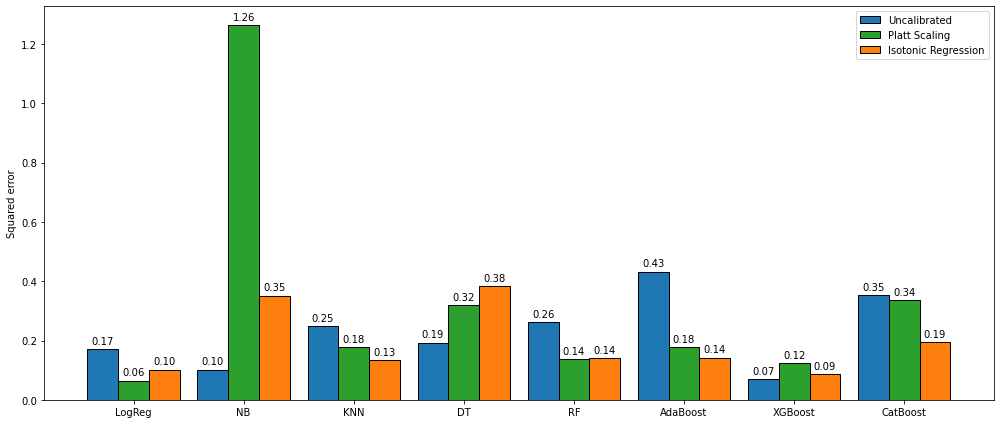

In [88]:
x = np.arange(len(labels))  # the label locations
width = 0.28  # the width of the bars

fig, ax = plt.subplots(figsize=(14,6))
rects1 = ax.bar(x - width, errors_uncalibrated, width, color="tab:blue", edgecolor="k", label='Uncalibrated')
rects2 = ax.bar(x, errors_sigmoid, width, color="tab:green", edgecolor="k", label='Platt Scaling')
rects3 = ax.bar(x + width, errors_isotonic, width, color="tab:orange", edgecolor="k", label='Isotonic Regression')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Squared error')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()
plt.savefig('plots/step8_calibration_errors.png', dpi=300, bbox_inches='tight')
plt.show()

## Plot AUC change

In [77]:
df_scores_auc = df_scores.copy()
df_scores_auc["calibration"] = "none"
df_scores_auc.loc[df_scores_auc.index.str.endswith("_platt"), "calibration"] = "platt"
df_scores_auc.loc[df_scores_auc.index.str.endswith("_isotonic"), "calibration"] = "isotonic"
df_scores_auc.index = df_scores_auc.index.str.replace("_platt", "", regex=False)
df_scores_auc.index = df_scores_auc.index.str.replace("_isotonic", "", regex=False)

auc_uncalibrated = df_scores_auc.loc[df_scores_auc["calibration"] == "none", "auc"].copy()
auc_platt = df_scores_auc.loc[df_scores_auc["calibration"] == "platt", "auc"].copy()
auc_isotonic = df_scores_auc.loc[df_scores_auc["calibration"] == "isotonic", "auc"].copy()
auc_uncalibrated = auc_uncalibrated.reindex(auc_platt.index)
# print(labels)
# print(auc_uncalibrated.index)
# print(auc_platt.index)
# print(auc_isotonic.index)

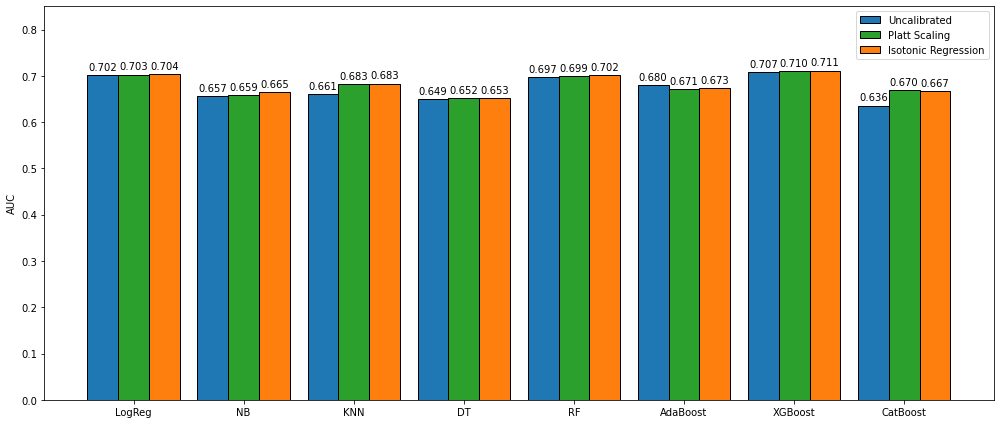

In [87]:
x = np.arange(len(labels))  # the label locations
width = 0.28  # the width of the bars

fig, ax = plt.subplots(figsize=(14,6))
rects1 = ax.bar(x - width, auc_uncalibrated, width, color="tab:blue", edgecolor="k", label='Uncalibrated')
rects2 = ax.bar(x, auc_platt, width, color="tab:green", edgecolor="k", label='Platt Scaling')
rects3 = ax.bar(x + width, auc_isotonic, width, color="tab:orange", edgecolor="k", label='Isotonic Regression')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('AUC')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()
plt.ylim([0, 0.85])

plt.savefig('plots/step8_calibration_auc.png', dpi=300, bbox_inches='tight')
plt.show()

# Learning Curves

In [15]:
def prep_data(X_train, X_val, y_train, y_val, X_features_list):
    under_sampler = TomekLinks()
    X_resampled, y_resampled = under_sampler.fit_resample(X_train, y_train)

    scaler = StandardScaler()
    scaler.fit(X_resampled)
    X_train_final = pd.DataFrame(scaler.transform(X_resampled), columns=X_train.columns)
    X_val_final = pd.DataFrame(scaler.transform(X_val), columns=X_train.columns)

    X_train_final = X_train_final[X_features_list].copy()
    X_val_final = X_val_final[X_features_list].copy()
    
    return X_train_final, X_val_final, y_resampled, y_val

def plot_learning_curves(model, df, X_features_list):
    X = df.drop(["wont_renew", "chapter_ID"], axis=1).copy()
    y = df["wont_renew"].copy()
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=710)
    train_errors, val_errors = [], []

    for m in range(100, len(X_train), 100):
        X_train_iter, X_val_iter, y_train_iter, y_val_iter = prep_data(X_train[:m], X_val, y_train[:m], y_val, X_features_list)

        model.fit(X_train_iter, y_train_iter)
        y_train_proba = model.predict_proba(X_train_iter)
        y_val_proba = model.predict_proba(X_val_iter)
        train_errors.append(roc_auc_score(y_train_iter, y_train_proba[:,1]))
        val_errors.append(roc_auc_score(y_val_iter, y_val_proba[:,1]))
    plt.plot(list(range(100, len(X_train), 100)), train_errors, linestyle="-", linewidth=2, color="tab:orange", label="train")
    plt.plot(list(range(100, len(X_train), 100)), val_errors, linestyle="-", linewidth=2, color="tab:blue", label="val")
    plt.xticks([x for x in range(100, len(X_train), 100)])
    plt.xlabel("Number of training samples")
    plt.ylabel("AUC")
    plt.legend()
    return train_errors[-1] - val_errors[-1]

## Learning Curves

0.028545072026051943


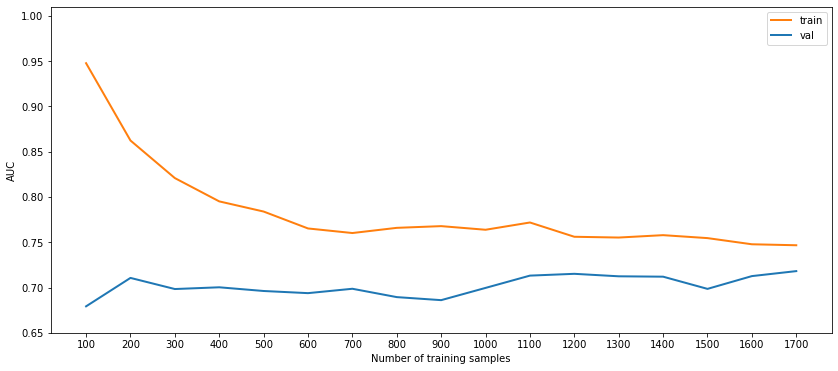

In [19]:
plt.figure(figsize=(14,6))
test_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc", random_state=42, use_label_encoder=False, **xg_cv.best_params_)
XGBoost_error = plot_learning_curves(test_model, df, xgb_10_features)
print(XGBoost_error)
plt.ylim([0.65, 1.01])
plt.savefig('plots/step9_learning_XGBoost.png', dpi=300, bbox_inches='tight')
plt.show()

0.004113556072378288


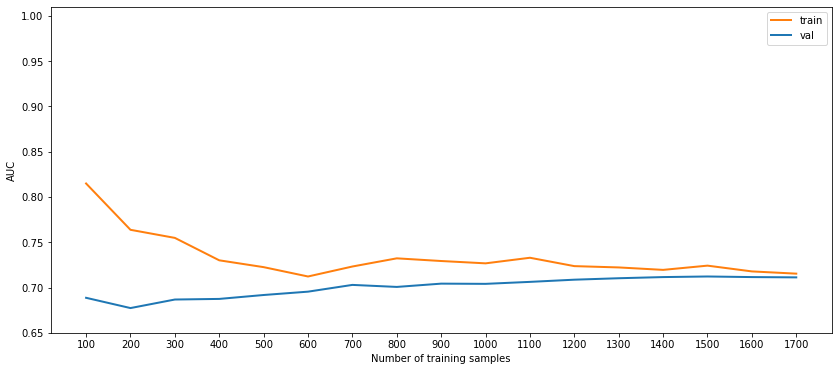

In [20]:
plt.figure(figsize=(14,6))
test_model = LogisticRegression(max_iter=5000, **logreg_cv.best_params_)
Logreg_error = plot_learning_curves(test_model, df, logreg_10_features)
print(Logreg_error)
plt.ylim([0.65, 1.01])
plt.savefig('plots/step9_learning_Logreg.png', dpi=300, bbox_inches='tight')
plt.show()

0.08766853912920691


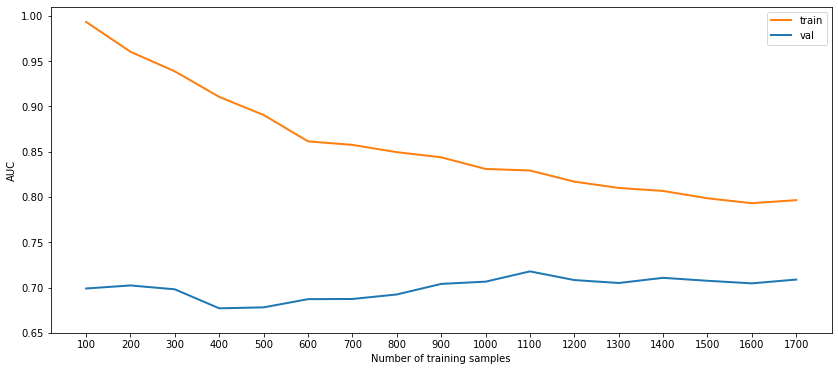

In [21]:
plt.figure(figsize=(14,6))
test_model = RandomForestClassifier(**rf_cv.best_params_)
RF_error = plot_learning_curves(test_model, df, rf_10_features)
print(RF_error)
plt.ylim([0.65, 1.01])
plt.savefig('plots/step9_learning_RF.png', dpi=300, bbox_inches='tight')
plt.show()